In [7]:
import re
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit

In [8]:
df_fq = pd.read_csv('../data/training/fecal_quality_2014_2019_pheno_metrics.csv')

In [9]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [10]:
df_fq['period'] = np.ceil(df_fq['Week of grazing season']/4).astype(int)

df_cp = df_fq[~df_fq['DOM'].isna()].copy()
df_cp = df_cp[df_cp['Treatment'] == 'TRM'].copy()
df_cp = df_cp[~df_cp['CP'].isna()].copy()

In [11]:
######
#df_cp = df_fq[df_fq['outlier'] != 1]  # remove suspected outliers
rand_st = 2313
cp_features = df_cp[['NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG', 'iNDVI_dry']]
# Saving feature names for later use
cp_feature_list = list(cp_features.columns)

df_cp['CP_grp'] = pd.qcut(df_cp['CP'], 5, labels=['low', 'modlow', 'avg', 'modhi', 'hi'])
CP_skf = StratifiedKFold(n_splits=10, random_state=rand_st, shuffle=True)
#CP_skf = StratifiedShuffleSplit(n_splits=40, test_size=0.2, random_state=rand_st)
CP_skf_cv = CP_skf.split(cp_features, df_cp['period'])

cp_labels = df_cp['CP']

In [12]:
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error'}
param_grid = {
    'RF__min_samples_split': [0.001, 0.01, 0.10],
    'RF__n_estimators': [100, 250, 500, 750],
    'RF__max_samples': [0.1, 0.25, 0.5, 0.75, 0.90],
    'RF__max_features': [2, 3, 4, 5],
}

CP_skf = StratifiedKFold(n_splits=10, random_state=rand_st, shuffle=True)
CP_skf_cv = CP_skf.split(cp_features, df_cp['period'])

# Create a based model
rf_cp_r2 = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_jobs=1))
                ])
# Instantiate the grid search model
cp_grid_search = GridSearchCV(estimator=rf_cp_r2, param_grid=param_grid,
                               scoring=scoring, refit='MSE', return_train_score=True,
                               cv=CP_skf_cv, n_jobs=-1, verbose=0)

# Fit the grid search to the data
cp_grid_search.fit(cp_features, cp_labels)
results = cp_grid_search.cv_results_

In [17]:
cp_grid_search.best_params_

{'RF__max_features': 2,
 'RF__max_samples': 0.25,
 'RF__min_samples_split': 0.01,
 'RF__n_estimators': 100}

In [13]:
print('R^2-CV: ' + str(results['mean_test_R2'][results['rank_test_MSE'] == 1]))
print('R^2-CV std: ' + str(results['std_test_R2'][results['rank_test_MSE'] == 1]))
print('MSE-CV: ' + str(-1.0 * results['mean_test_MSE'][results['rank_test_MSE'] == 1]))
print('MSE-CV std: ' + str(results['std_test_MSE'][results['rank_test_MSE'] == 1]))
print('RMSE-CV: ' + str(np.mean(
    np.sqrt([-1.0 * value[results['rank_test_MSE'] == 1] for
             key, value in results.items() if re.search('split+\d_train_MSE', key)]))))
print('RMSE-CV std: ' + str(np.std(
    np.sqrt([-1.0 * value[results['rank_test_MSE'] == 1] for
             key, value in results.items() if re.search('split+\d_train_MSE', key)]))))

R^2-CV: [0.77513019]
R^2-CV std: [0.10458314]
MSE-CV: [1.12993884]
MSE-CV std: [0.33363522]
RMSE-CV: 0.8353225871983652
RMSE-CV std: 0.018449577628722805


In [14]:
df_results = pd.DataFrame({k:results[k] for k in results.keys() if not k.startswith('split')})

In [15]:
df_results.loc[df_results['param_RF__max_samples'] == None, 'param_RF__max_samples'] = 'None'

In [16]:
df_results['param_RF__max_samples'] = df_results['param_RF__max_samples'].astype(str)

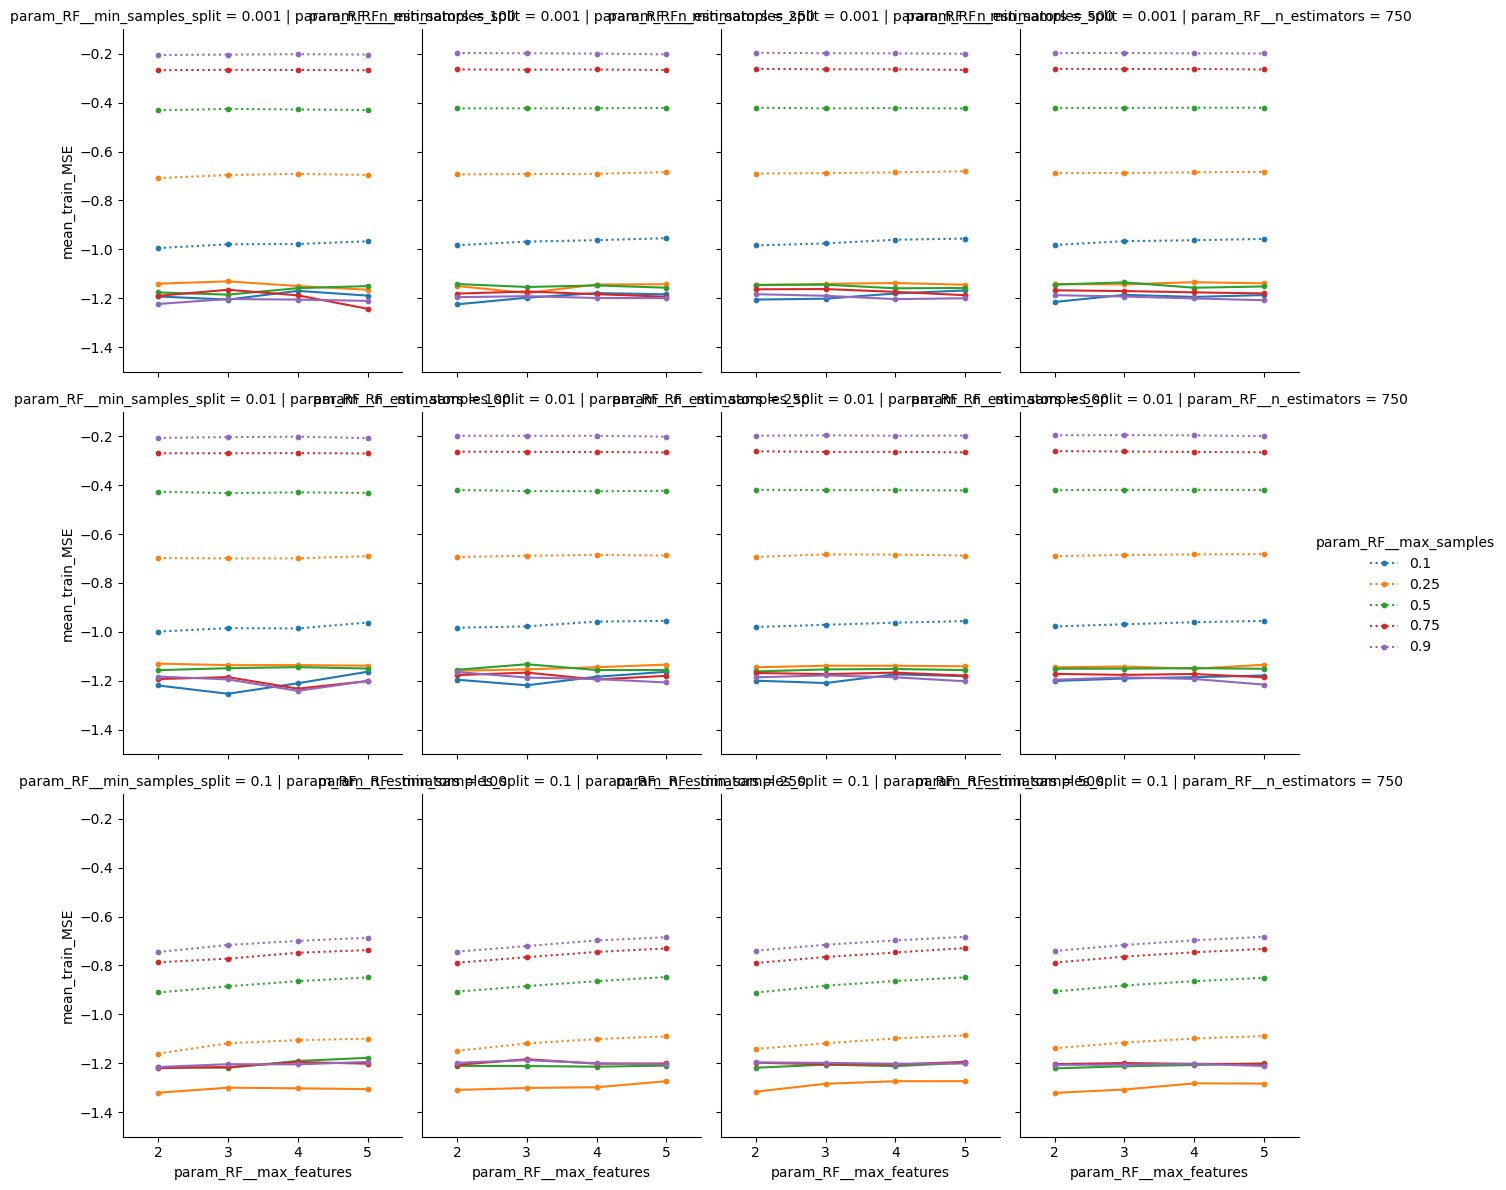

In [18]:
p = sns.FacetGrid(data=df_results,
                  hue='param_RF__max_samples', 
                  row='param_RF__min_samples_split',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_MSE', markersize=3, linewidth=1.5)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_MSE', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    ax.set_ylim((-1.5, -0.1))
p.add_legend()

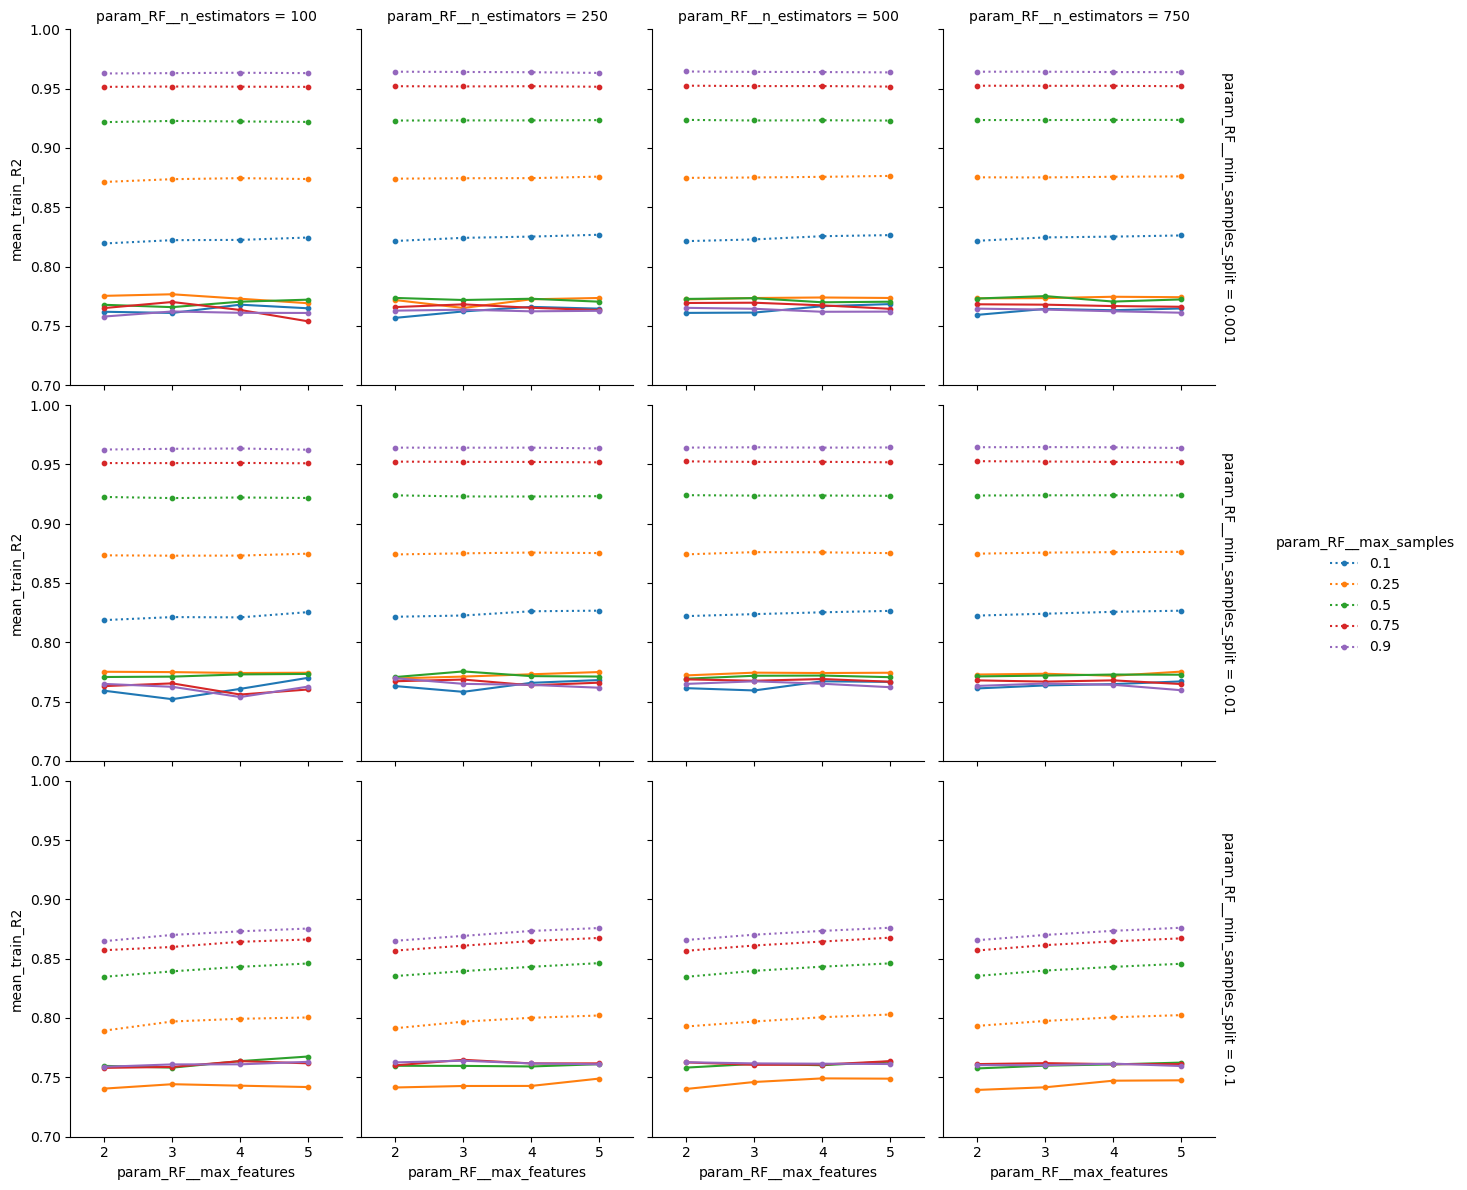

In [19]:
p = sns.FacetGrid(data=df_results,
                  hue='param_RF__max_samples', 
                  row='param_RF__min_samples_split',
                  col='param_RF__n_estimators',
                  height=4, aspect=0.8, margin_titles=True)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_test_R2', markersize=3, linewidth=1.5)
p.map_dataframe(sns.pointplot, x='param_RF__max_features', y='mean_train_R2', linestyle='dotted', markersize=3, linewidth=1.5)
for ax in p.axes.flat:
    ax.set_ylim((0.7, 1.0))
p.add_legend()

In [20]:
max_features = 3
n_estimators = 100
min_samples_split = 0.001
max_samples = 0.5
best_result_manual = df_results[(df_results['param_RF__max_features'] == max_features) &
(df_results['param_RF__n_estimators'] == n_estimators) &
(df_results['param_RF__min_samples_split'] == min_samples_split) &
(df_results['param_RF__max_samples'] == str(max_samples))]
display(best_result_manual.drop(columns=['params']))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RF__max_features,param_RF__max_samples,param_RF__min_samples_split,param_RF__n_estimators,mean_test_R2,std_test_R2,rank_test_R2,mean_train_R2,std_train_R2,mean_test_MSE,std_test_MSE,rank_test_MSE,mean_train_MSE,std_train_MSE
84,0.114722,0.001115,0.005712,0.000041,3,0.5,0.001,100,0.765787,0.102675,96,0.922771,0.003259,-1.185225,0.330452,103,-0.425465,0.010819


In [21]:
print('R^2-CV: ' + str(results['mean_test_R2'][results['rank_test_MSE'] == 10]))
print('R^2-CV std: ' + str(results['std_test_R2'][results['rank_test_MSE'] == 10]))
print('MSE-CV: ' + str(-1.0 * results['mean_test_MSE'][results['rank_test_MSE'] == 10]))
print('MSE-CV std: ' + str(results['std_test_MSE'][results['rank_test_MSE'] == 10]))
print('RMSE-CV: ' + str(np.mean(
    np.sqrt([-1.0 * value[results['rank_test_MSE'] == 10] for
             key, value in results.items() if re.search('split+\d_train_MSE', key)]))))
print('RMSE-CV std: ' + str(np.std(
    np.sqrt([-1.0 * value[results['rank_test_MSE'] == 10] for
             key, value in results.items() if re.search('split+\d_train_MSE', key)]))))

R^2-CV: [0.77392874]
R^2-CV std: [0.10704451]
MSE-CV: [1.13763416]
MSE-CV std: [0.35030396]
RMSE-CV: 0.8276030284373164
RMSE-CV std: 0.014419298607511379


In [24]:
# Create a based model
rf_cp_fnl = Pipeline(
                [
                    ('scaler', StandardScaler()), 
                    ('RF', RandomForestRegressor(n_estimators=n_estimators,
                                                 max_features=max_features, 
                                                 min_samples_split=min_samples_split, 
                                                 max_samples=max_samples,
                                                 n_jobs=-1))
                ])
rf_cp_fnl.fit(cp_features, cp_labels)

# Use the forest's predict method on the test data
pred_cp = rf_cp_fnl.predict(cp_features)
# Calculate the absolute errors_cp
errors_cp = np.mean((pred_cp - cp_labels)**2)
# Print out the mean absolute error (mae)
print('RMSE:', round(np.sqrt(np.mean(errors_cp)), 2))
#plt.figure()
#plt.scatter(pred_cp, cp_labels)
#abline(1, 0)

RMSE: 0.64


In [26]:
df_cp['CP_pred'] = pred_cp
df_fq['CP_pred'] = rf_cp_fnl.predict(df_fq[['NDVI', 'NDVI_d30', 'iNDVI', 't_peak_IRG', 'iNDVI_dry']])

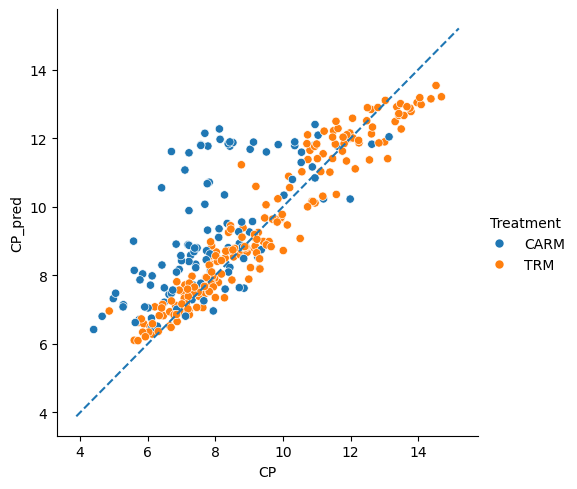

In [27]:
p = sns.relplot(x='CP', y='CP_pred', hue='Treatment', data=df_fq)
abline(1, 0)

In [ ]:
import pickle
pickle.dump(rf_cp_fnl, open('../models/diet_quality/rf_cp_ndvi_2014_2019.pkl', 'wb'))